# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
import random
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [3]:
data.head(10)

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3
5,m3,a4
6,m3,a5
7,m3,a6
8,m3,a7
9,m4,a1


In [4]:
edges = [tuple(x) for x in data.values.tolist()]

In [5]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [6]:
#A = list(nx.connected_component_subgraphs(B))[0]
#https://stackoverflow.com/questions/61154740/attributeerror-module-networkx-has-no-attribute-connected-component-subgraph
#The attribute subgraph has been deprecated

A= list(B.subgraph(c) for c in nx.connected_components(B))[0]

In [7]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


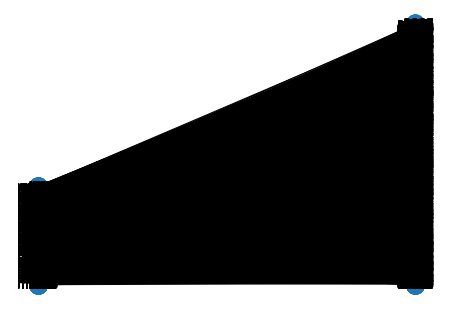

In [8]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [9]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [10]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [11]:
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=128, window=5)

In [12]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [13]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

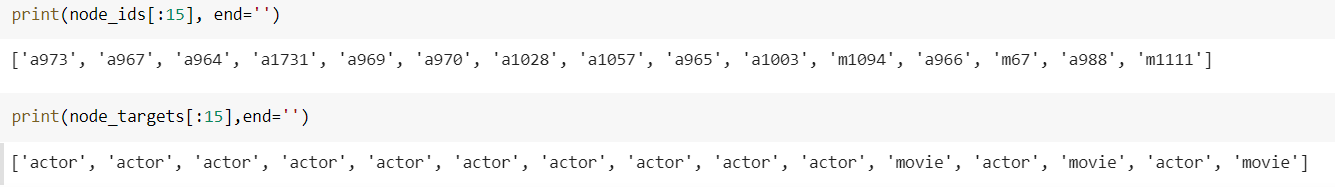

In [14]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for i in range(len(node_embeddings)):
        if 'a' in node_ids[i]:
            actor_nodes.append(node_ids[i])
            actor_embeddings.append(node_embeddings[i])
        else:
            movie_nodes.append(node_ids[i])
            movie_embeddings.append(node_embeddings[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [15]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [16]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [17]:
#Assume that a graph has been generated using the Nodes & edges which are created
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    g=list(graph.subgraph(i) for i in nx.connected_components(graph))#Converting the whole graph to subgraphs
    max_edge=max(list(m.number_of_nodes() for m in g))#Finding the edge with max
    #print(max_edge)
    total_nodes=len(graph.nodes())#Total Nodes
    #print(total_nodes)
    cost1=1/number_of_clusters*(max_edge/total_nodes)
    return cost1

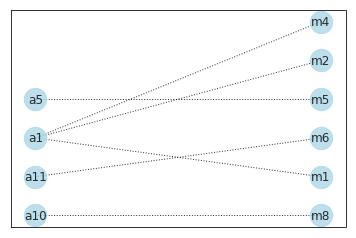

In [18]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [19]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [20]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    sub_g=list(graph.subgraph(j) for j in nx.connected_components(graph))#Converting the whole Graph to subgraphs
    
    sum_of_degree=sum(list(m[1] for m in graph.degree()))/2#Calculating the degree of each node in the whole graph
    #Dividing by 2, because each node has been calculated twice
    
    edges=list(g for g in graph.edges())#Calculating the edges
    
    unique_denominator=len(set(a[1] for a in edges))#Finding unique values in the other end
    
    cost2= 1/number_of_clusters*(sum_of_degree/unique_denominator)
    #print(sum_of_degree)
    #print(unique_denominator)
    #print(cost2)
    return cost2

<font color='cyan'>Grader function - 4</font>

In [21]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [22]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings
result_actors=[]
value_of_clusters=[3, 5, 10, 30, 50, 100, 200, 500]
for number_of_clusters in value_of_clusters:
    algo=KMeans(n_clusters=number_of_clusters)
    algo.fit(actor_embeddings)
    cluster_label=algo.labels_
    scores=[]
    for i in range(number_of_clusters):
        Y=nx.Graph()
        index=np.where(cluster_label==i)[0].tolist()
        nodes=list(actor_nodes[i] for i in index)
        for n in nodes:
            e=nx.ego_graph(B,n)
            Y.add_nodes_from(e.nodes())
            Y.add_edges_from(e.edges())
        c1=cost1(Y,number_of_clusters)
        c2=cost2(Y,number_of_clusters)
        sc=c1*c2
        scores.append(sc)
    result_actors.append(sum(scores))
print('The best score is for {} clusters'.format(value_of_clusters[result_actors.index(max(result_actors))]))

The best score is for 3 clusters


In [23]:
algo_actors=KMeans(n_clusters=3)
algo_actors.fit(actor_embeddings)
labels_actors=algo_actors.labels_

<font color='blue'>Displaying similar actor clusters</font>

In [24]:
reducer_actors=TSNE(n_components=2,n_jobs=-1)
d_value_actors=reducer_actors.fit_transform(actor_embeddings)

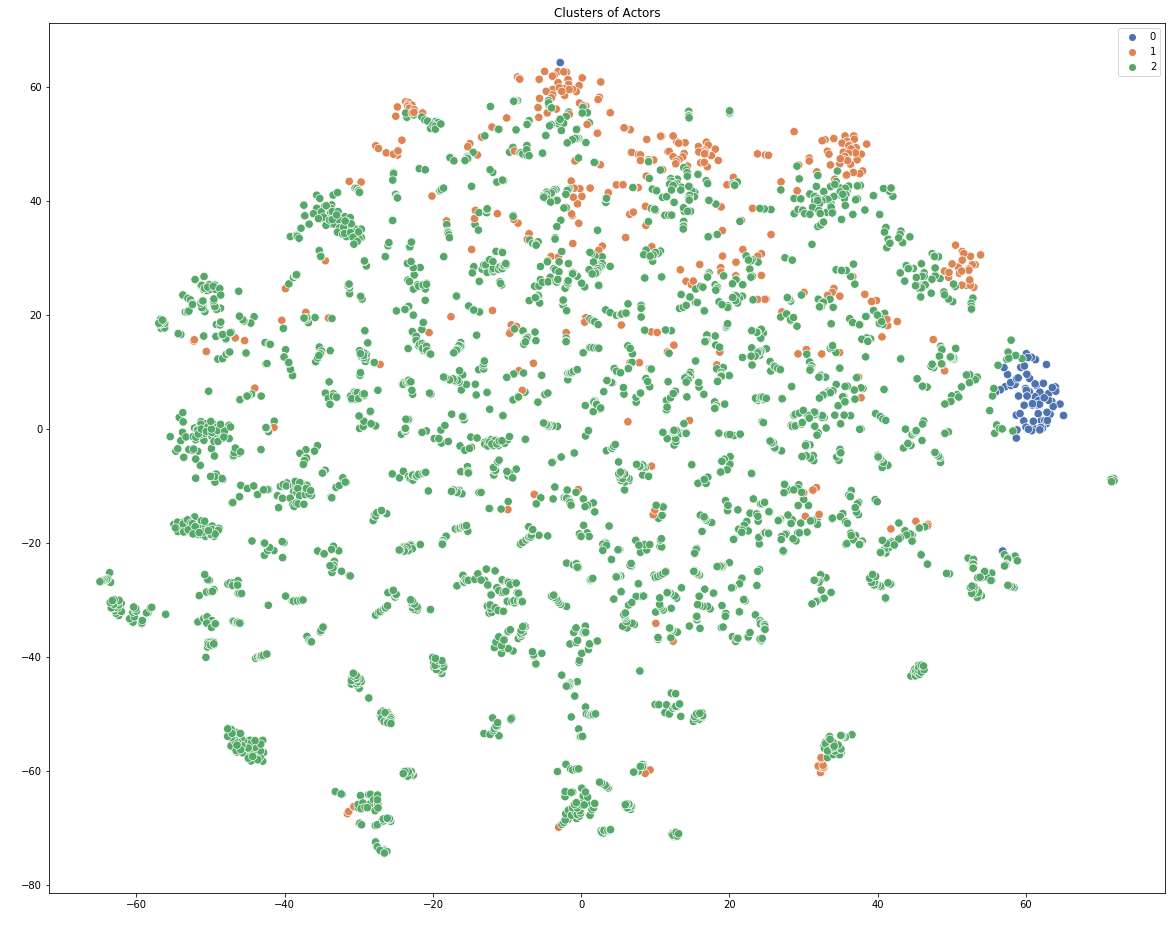

In [25]:
d_value_actors
plt.figure(figsize=(20,16))
sns.scatterplot(x=d_value_actors[:,0],y=d_value_actors[:,1],hue=labels_actors,palette="deep",s=70)
plt.xlabel(" ")
plt.ylabel(' ')
plt.title('Clusters of Actors')
plt.show()

<font color='blue'>Grouping similar movies</font>

In [26]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings
result_movies=[]
value_of_clusters=[3, 5, 10, 30, 50, 100, 200, 500]

for number_of_clusters in value_of_clusters:
    algo=KMeans(n_clusters=number_of_clusters)
    algo.fit(movie_embeddings)
    cluster_label=algo.labels_
    scores=[]
    for i in range(number_of_clusters):
        Y=nx.Graph()
        index=np.where(cluster_label==i)[0].tolist()
        nodes=list(actor_nodes[i] for i in index)
        for n in nodes:
            e=nx.ego_graph(B,n)
            Y.add_nodes_from(e.nodes())
            Y.add_edges_from(e.edges())
        c1=cost1(Y,number_of_clusters)
        c2=cost2(Y,number_of_clusters)
        sc=c1*c2
        scores.append(sc)
        result_movies.append(sum(scores))
print('The best score is for {} clusters'.format(value_of_clusters[result_movies.index(max(result_movies))]))

The best score is for 10 clusters


In [27]:
algo_movies=KMeans(n_clusters=10)
algo_movies.fit(movie_embeddings)
labels_movies=algo_movies.labels_

<font color='blue'>Displaying similar movie clusters</font>

In [28]:
reducer_movies=TSNE(n_components=2,perplexity=30,n_jobs=-1)
d_value_movies=reducer_movies.fit_transform(movie_embeddings)

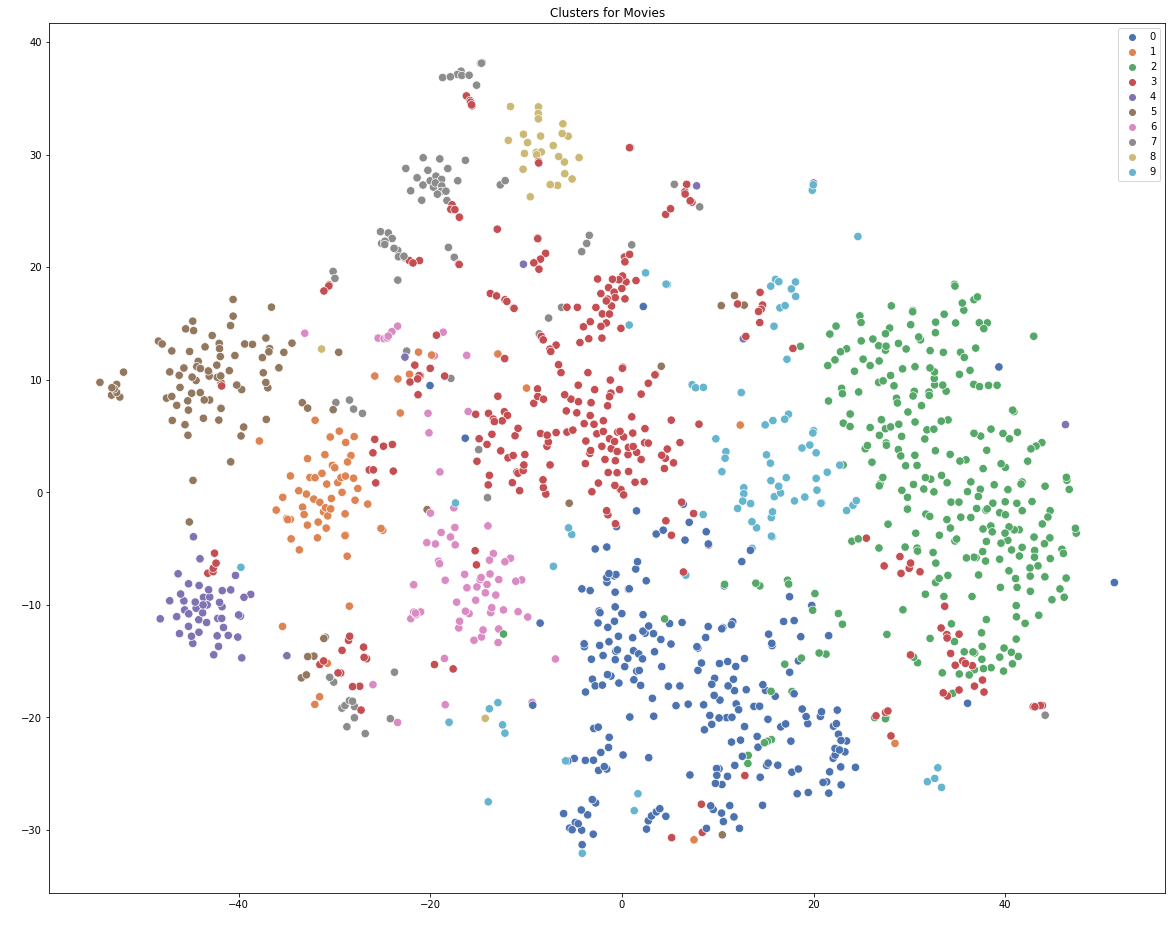

In [29]:
plt.figure(figsize=(20,16))
sns.scatterplot(x=d_value_movies[:,0],y=d_value_movies[:,1],hue=labels_movies,palette="deep",s=70)
plt.xlabel(" ")
plt.ylabel(' ')

plt.title('Clusters for Movies')
plt.show()